# Structural Estimation of a Full Blow Consumption Model

1. Go through the **ConsumptionSaving.pdf** slides
2. This notebooks estimates the presented model using **egm** to solve the model for guesses over parameter values
3. Show how to calculate standard errors and sensitivity measures

# Setup

In [18]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import time
import numpy as np
import scipy.optimize as optimize

import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

import figs
from ConsumptionSavingModel import ConsumptionSavingModelClass

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Setup estimation details

In [2]:
# parameters to estimate
est_par = {
    'rho': {'guess':2.0,'lower':0.5,'upper':5.0,},
    'beta': {'guess':0.97,'lower':0.90,'upper':0.999},
}

# moment function used in estimation
def mom_func(data):
    '''Returns the age profile of wealth '''
    
    return np.mean(data.A,axis=0)

# Setup Consumption model and simulate synthetic data 

model solved in 2.0 secs
model simulated in 1.7 secs


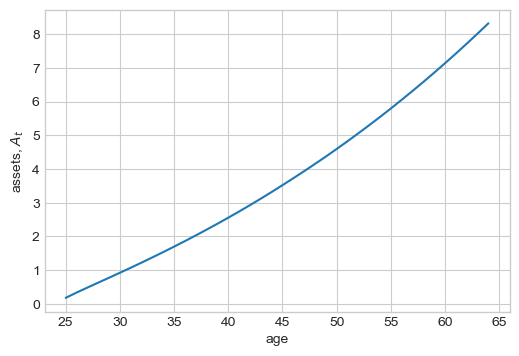

In [4]:
# true parameters
par_true = {}
par_true['rho'] = 1.5
par_true['beta'] = 0.98

# simulation setup
par_true['sim_mini'] = 1.0 # initial resources
par_true['simlifecycle'] = 1
par_true['simT'] = 40

model = ConsumptionSavingModelClass(name='baseline',solmethod='egm',**par_true)

# estimation setup
model.est_par = est_par
model.mom_func = mom_func

# synthetic data and moments
model_true = model.copy()
model_true.solve()
model_true.simulate(seed=2019) # this is different from the default

model.datamoms = mom_func(model_true.sim)
figs.plot_life_cycle_assets(model_true)

# Estimate

## Estimation functions

In [19]:
def obj_func(theta,model,W,names,lower,upper):

    # impose bounds and calculate penalty
    penalty = 0.0
    theta_clipped = theta.copy()
    for i in range(theta.size):
        
        # i. clip
        if (lower[i] != None) or (upper[i] != None):
            theta_clipped[i] = np.clip(theta_clipped[i],lower[i],upper[i])
        
        # ii. penalty
        penalty += 10_000.0*(theta[i]-theta_clipped[i])**2
    
    # calcualte the vector of differences between moments in data and in simulated data
    diff = diff_vec_func(theta_clipped,names,model,model.datamoms)
    
    # return the objective function
    objval = diff.T @ W @ diff 
    return objval + penalty

def diff_vec_func(theta,names,model,moms_data):
    
    # a. update parameters in par
    for i in range(theta.size):
        setattr(model.par,names[i],theta[i])

    # b. solve model
    model.solve(do_print=False)
    
    # c. simulate model
    model.simulate(do_print=False)

    # calculate moments in simulated data
    moms_sim = model.mom_func(model.sim)
    
    # return the vector of differences
    return moms_data - moms_sim

In [20]:
# initial guesses
theta0 = np.array([val['guess'] for key,val in est_par.items()])
names = [key for key,val in est_par.items()]

# bounds
lower = np.array([val['lower'] for key,val in est_par.items()])
upper = np.array([val['upper'] for key,val in est_par.items()])

# weighting matrix
W = np.eye(moms_data.size) # identifty

# evaluate the objective function
print(f'Objective function at starting values: {obj_func(theta0,model,W,names,lower,upper)}')

Objective function at starting values: 411.86047926020666


## Call numerical solver to estimate theta

In [22]:
method = 'nelder-mead' 
res = optimize.minimize(obj_func,theta0,args=(model,W,names,lower,upper),
                            method=method)
# options={'disp':disp,'maxiter':max_iter,'xatol': model.par.est_tol,'fatol': model.par.est_tol})

In [23]:
res

 final_simplex: (array([[1.50295395, 0.98000657],
       [1.50304636, 0.98000725],
       [1.50304354, 0.98000722]]), array([4.77754407e-05, 4.77779641e-05, 4.77781567e-05]))
           fun: 4.777544073469529e-05
       message: 'Optimization terminated successfully.'
          nfev: 144
           nit: 77
        status: 0
       success: True
             x: array([1.50295395, 0.98000657])